# Part 1: Plotting Contact Maps w/ Cooltools

In [8]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cooltools
import cooler

from matplotlib.colors import LogNorm
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

# set plotting / formatting standards
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

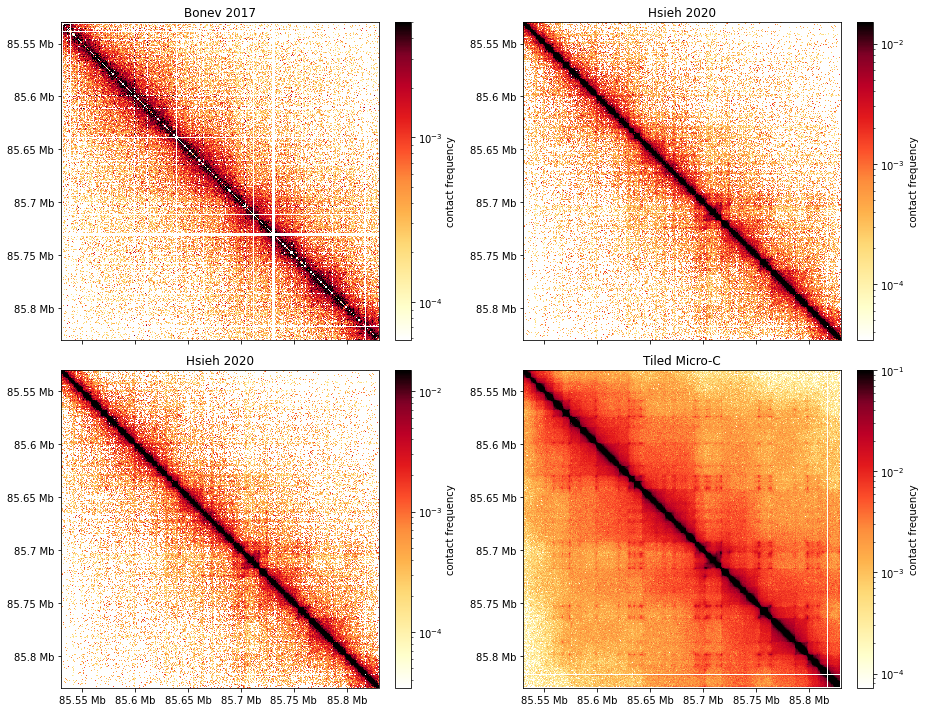

In [9]:
# REGION_NAME @ X BP RESOLUTION

saveDir = f'DIRECTORY_PATH'
fileName = f'FILE_NAME.svg' # swap out .svg for the desired output file format
res = 500

# load in .mcools for datasets of interest at the desired resolution
clr_RCMC = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(res))
clr_Hsieh = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(res))
clr_Bonev = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(res))

region = 'chr8:85,530,000-85,830,000' # example mm39 coordinates for visualizing microcompartments in the Klf1 region, for fetching the region
start, end = 85_530_000, 85_830_000 # same coordinates as 'region' above, now for setting the plotted viewing window
extents = (start, end, end, start)
norm_balanced = LogNorm(vmax=0.1,vmin=0.00007) # logarithmic bounds for contact scaling, for consistency across datasets


f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=False
)

ax = axs[1,1]
ax.set_title('Region Capture Micro-C')
im = ax.matshow(
    clr_RCMC.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced,
    extent=extents
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='contact frequency');

ax = axs[0,1]
ax.set_title('Hsieh 2020 Micro-C')
im2 = ax.matshow(
    clr_Hsieh.matrix(balance=True).fetch(region),
    cmap='fall',
    norm=norm_balanced,
    extent=extents
);
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='contact frequency');

ax = axs[1,0]
ax.set_title('Hsieh 2020 Micro-C')
im2 = ax.matshow(
    clr_Hsieh.matrix(balance=True).fetch(region),
    cmap='fall',
    norm=norm_balanced,
    extent=extents
);
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='contact frequency');

ax = axs[0,0]
ax.set_title('Bonev 2017 Hi-C')
im2 = ax.matshow(
    clr_Bonev.matrix(balance=True).fetch(region),
    cmap='fall',
    norm=norm_balanced,
    extent=extents
);
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='contact frequency');

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()

# plt.savefig(saveDir + fileName, dpi=1200)

# Part 2: Plotting ChIP Tracks & Gene Annotations w/ Coolbox

In [1]:
# Jupyter Notebook formatting change to make it easier to visualize output results without having to scroll
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [15]:
# Style formatting change for ease of visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
from scipy.sparse import coo_matrix
from coolbox.api import *
import coolbox
from coolbox.core.track.hicmat import Cool
from coolbox.utilities import GenomeRange, correspond_track
import bbi

import numpy as np # for manipulating arrays
import os # for making/deleting directories
import pickle # for saving python objects and other data
from pathlib import Path
import cooler

# for plotting images
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation

# set plotting parameters & standard settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 6})

def gridspec_inches(
    wcols,
    hrows,
    wspace=0.75,
    hspace=0.5,
    fig_kwargs={}):

    fig = plt.figure()
    fig_height_inches = (
        sum(hrows)
        )

    fig_width_inches = (
        sum(wcols)
        )

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=matplotlib.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = matplotlib.gridspec.GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=wspace,
        hspace=hspace,
        width_ratios=wcols,
        height_ratios=hrows
        )
    return fig, gs

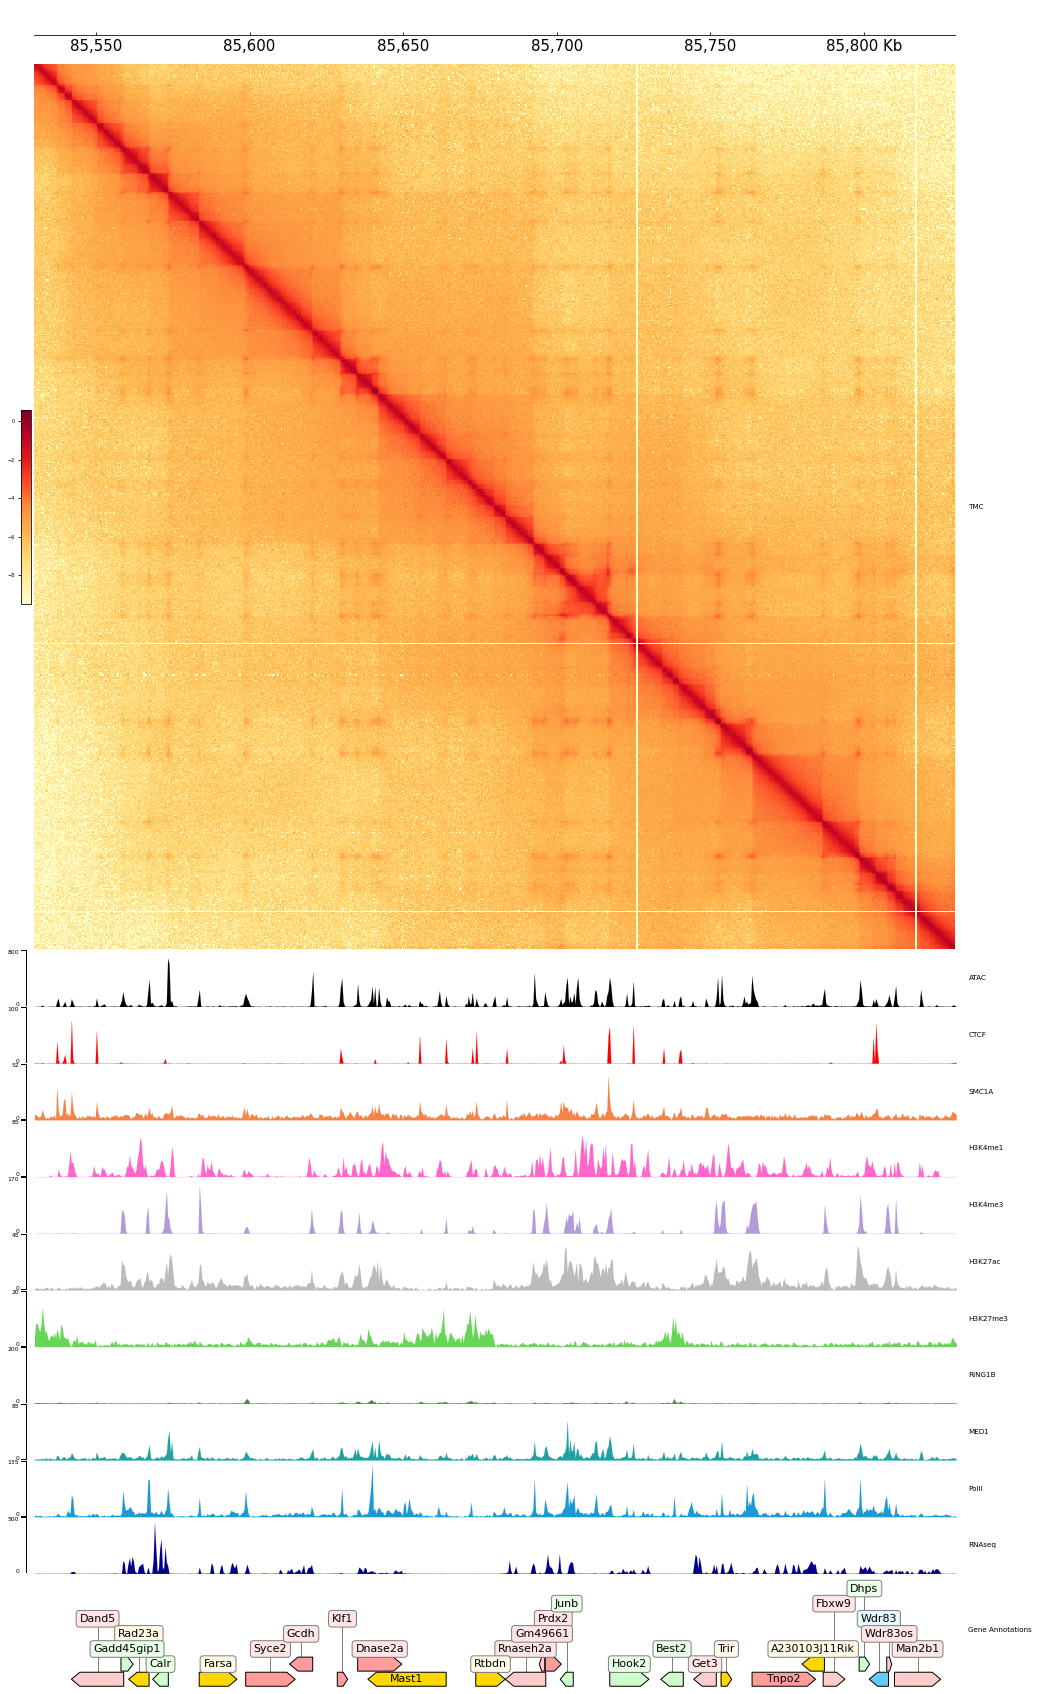

In [20]:
# REGION_NAME @ X BP RESOLUTION

saveDir = f'DIRECTORY_PATH'
fileName = f'FILE_NAME.svg' # swap out .svg for the desired output file format
res = 500

reg ="chr8:85,530,000-85,830,000" # example mm39 coordinates for visualizing microcompartments in the Klf1 region, for fetching the region

heatmap = XAxis() + \
Cool(f"FILE_PATH_TO_MCOOL", resolution=res, style="matrix", depth_ratio=0.85, balance=True, cmap="YlOrRd") + Title("RCMC")

CTCF = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF") + Color("#FF0000") + MaxValue(100) + MinValue(0)

SMC1A = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("SMC1A") + Color("#F38346") + MaxValue(52) + MinValue(0)

H3K4me1 = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K4me1") + Color("#FF66CC") + MaxValue(85) + MinValue(0)

H3K27ac = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K27ac") + Color("#BBBBBB") + MaxValue(45) + MinValue(0)

H3K4me3 = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K4me3") + Color("#B19CD9") + MaxValue(170) + MinValue(0)

annotations = \
GTF('FILE_PATH_TO_GTF') + TrackHeight(4) + Title("Gene Annotations")

RNAseq = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RNAseq") + Color("#00008B") + MaxValue(500) + MinValue(0)

MED1 = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("MED1") + Color("#1EA1A1") + MaxValue(85) + MinValue(0)

PolII = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("PolII") + Color("#1A99D5") + MaxValue(135) + MinValue(0)

RING1B = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RING1B") + Color("#3E8233") + MaxValue(200) + MinValue(0)

ATAC = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("ATAC") + Color("#000000") + MaxValue(800) + MinValue(0)

H3K27me3 = \
BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K27me3") + Color("#67D556") + MaxValue(20) + MinValue(0)

frame = heatmap + ATAC + CTCF + SMC1A + H3K4me1 + H3K4me3 + H3K27ac + H3K27me3 + RING1B + MED1 + PolII + RNAseq + annotations
fig = frame.plot(reg)

#fig.savefig(saveDir + fileName, dpi=1200)
fig